# Forecasting Tidal Dynamics Across Hawaiian Islands: A Multivariate Time Series Analysis Using LSTM, Transformers, and Seasonal Models
The project focuses on leveraging advanced deep learning techniques to analyze and forecast tidal behavior across multiple Hawaiian islands. Tidal levels are influenced by complex environmental factors such as moon phases, atmospheric pressure, and climate patterns. Understanding these variations is essential for coastal management, climate impact assessment, and environmental monitoring.The goal of this project is to create a robust model that predicts multiple tidal features, such as Highest Tide, Mean Sea Level (MSL), and Lowest Tide, using historical multivariate time-series data. To achieve this, we will employ a combination of Long Short-Term Memory (LSTM) networks, known for capturing short- and medium-term dependencies in time series data, and Transformer models, which excel at handling long-term forecasting and sequence prediction.
This study will investigate how different tidal features interact and contribute to future predictions. The results from this project will not only provide accurate short- and long-term forecasts but will also help reveal the underlying patterns and trends in tidal data that could be vital for planning coastal infrastructure, managing flood risks, and studying the effects of climate change on sea levels. 

## Data Source:
The dataset includes the following stations: https://tidesandcurrents.noaa.gov/
- 1617760 Hilo, HI
- 1612340 - Honolulu, HI
- 1617433 - Kawaihae, HI 
- 1611400 - Nawiliwili, 





In [77]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [78]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [79]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  

# Advanced Deep Learning 
from tensorflow.keras.layers import Input, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Model


# Interpolation and Signal Processing
from scipy.interpolate import UnivariateSpline
from scipy.signal import correlate  
from scipy.fft import fft  


## Data Preprocessing

In [82]:
hilo_df = pd.read_csv('Hilo.csv')
honolulu_df = pd.read_csv('Honolulu.csv')
kawaihae_df = pd.read_csv('Kawaihae.csv')
nawiliwili_df = pd.read_csv('Nawiliwili.csv')

In [83]:
print(hilo_df.columns)
hilo_df['Date'] = pd.to_datetime(hilo_df['Date'])
honolulu_df['Date'] = pd.to_datetime(honolulu_df['Date'])
kawaihae_df['Date'] = pd.to_datetime(kawaihae_df['Date'])
nawiliwili_df['Date'] = pd.to_datetime(nawiliwili_df['Date'])

print("Data Types for Hilo:")
print(hilo_df.dtypes)
print("\nData Types for Honolulu:")
print(honolulu_df.dtypes)
print("\nData Types for Kawaihae:")
print(kawaihae_df.dtypes)
print("\nData Types for Nawiliwili:")
print(nawiliwili_df.dtypes)


Index(['Date', 'Time (GMT)', 'Highest', 'MHHW (ft)', 'MHW (ft)', 'MSL (ft)',
       'MTL (ft)', 'MLW (ft)', 'MLLW (ft)', 'Lowest (ft)', 'Inf'],
      dtype='object')
Data Types for Hilo:
Date           datetime64[ns]
Time (GMT)             object
Highest               float64
MHHW (ft)             float64
MHW (ft)              float64
MSL (ft)              float64
MTL (ft)              float64
MLW (ft)              float64
MLLW (ft)             float64
Lowest (ft)           float64
Inf                     int64
dtype: object

Data Types for Honolulu:
Date           datetime64[ns]
Time (GMT)             object
Highest               float64
MHHW (ft)             float64
MHW (ft)              float64
MSL (ft)              float64
MTL (ft)              float64
MLW (ft)              float64
MLLW (ft)             float64
Lowest (ft)           float64
Inf                     int64
dtype: object

Data Types for Kawaihae:
Date           datetime64[ns]
Time (GMT)             object
Highest      

In [84]:

print(hilo_df.head())
print(honolulu_df.head())

        Date Time (GMT)  Highest  MHHW (ft)  MHW (ft)  MSL (ft)  MTL (ft)  \
0 1974-01-01      00:00    3.477      2.424       NaN     1.105       NaN   
1 1974-02-01      00:00    3.077      2.126       NaN     0.836       NaN   
2 1974-03-01      00:00    2.575      2.247       NaN     1.046       NaN   
3 1974-04-01      00:00    2.877      2.306       NaN     1.076       NaN   
4 1974-05-01      00:00    2.877      2.306       NaN     1.056       NaN   

   MLW (ft)  MLLW (ft)  Lowest (ft)  Inf  
0       NaN     -0.115       -0.725    0  
1       NaN     -0.263       -0.624    0  
2       NaN      0.065       -0.725    0  
3       NaN     -0.076       -0.725    0  
4       NaN     -0.155       -0.725    0  
        Date Time (GMT)  Highest  MHHW (ft)  MHW (ft)  MSL (ft)  MTL (ft)  \
0 1974-01-01      00:00    3.091      2.090     1.601     1.030     1.001   
1 1974-02-01      00:00    2.490      1.890     1.470     0.883     0.860   
2 1974-03-01      00:00      NaN      1.752     

In [85]:
hilo_df['Station'] = 'Hilo'
honolulu_df['Station'] = 'Honolulu'
kawaihae_df['Station'] = 'Kawaihae'
nawiliwili_df['Station'] = 'Nawiliwili'

hilo_df = hilo_df.drop(columns=['Inf'])
honolulu_df = honolulu_df.drop(columns=['Inf'])
kawaihae_df = kawaihae_df.drop(columns=['Inf'])
nawiliwili_df = nawiliwili_df.drop(columns=['Inf'])

# Preview the updated datasets
print(hilo_df.head())
print(honolulu_df.head())
print(kawaihae_df.head())
print(nawiliwili_df.head())


        Date Time (GMT)  Highest  MHHW (ft)  MHW (ft)  MSL (ft)  MTL (ft)  \
0 1974-01-01      00:00    3.477      2.424       NaN     1.105       NaN   
1 1974-02-01      00:00    3.077      2.126       NaN     0.836       NaN   
2 1974-03-01      00:00    2.575      2.247       NaN     1.046       NaN   
3 1974-04-01      00:00    2.877      2.306       NaN     1.076       NaN   
4 1974-05-01      00:00    2.877      2.306       NaN     1.056       NaN   

   MLW (ft)  MLLW (ft)  Lowest (ft) Station  
0       NaN     -0.115       -0.725    Hilo  
1       NaN     -0.263       -0.624    Hilo  
2       NaN      0.065       -0.725    Hilo  
3       NaN     -0.076       -0.725    Hilo  
4       NaN     -0.155       -0.725    Hilo  
        Date Time (GMT)  Highest  MHHW (ft)  MHW (ft)  MSL (ft)  MTL (ft)  \
0 1974-01-01      00:00    3.091      2.090     1.601     1.030     1.001   
1 1974-02-01      00:00    2.490      1.890     1.470     0.883     0.860   
2 1974-03-01      00:00      N

In [92]:
# Function for spline interpolation
def spline_interpolation(df, column):
    # Indices of valid (non-missing) and missing values
    valid_indices = df[column].notnull()
    missing_indices = df[column].isnull()

    # Spline interpolation function based on valid values
    spline = UnivariateSpline(df[valid_indices].index, df.loc[valid_indices, column], k=2, s=0)

    # Apply the spline to estimate missing values
    df.loc[missing_indices, column] = spline(df[missing_indices].index)

# Spline interpolation on the 'Highest' column for all datasets
spline_interpolation(hilo_df, 'Highest')
spline_interpolation(honolulu_df, 'Highest')
spline_interpolation(kawaihae_df, 'Highest')
spline_interpolation(nawiliwili_df, 'Highest')

# Spline interpolation for 'MHHW (ft)' column
spline_interpolation(hilo_df, 'MHHW (ft)')
spline_interpolation(honolulu_df, 'MHHW (ft)')
spline_interpolation(kawaihae_df, 'MHHW (ft)')
spline_interpolation(nawiliwili_df, 'MHHW (ft)')

# Spline interpolation for 'MHW (ft)' column
spline_interpolation(hilo_df, 'MHW (ft)')
spline_interpolation(honolulu_df, 'MHW (ft)')
spline_interpolation(kawaihae_df, 'MHW (ft)')
spline_interpolation(nawiliwili_df, 'MHW (ft)')

# Spline interpolation for 'MSL (ft)' column
spline_interpolation(hilo_df, 'MSL (ft)')
spline_interpolation(honolulu_df, 'MSL (ft)')
spline_interpolation(kawaihae_df, 'MSL (ft)')
spline_interpolation(nawiliwili_df, 'MSL (ft)')

# Spline interpolation for 'MTL (ft)' column
spline_interpolation(hilo_df, 'MTL (ft)')
spline_interpolation(honolulu_df, 'MTL (ft)')
spline_interpolation(kawaihae_df, 'MTL (ft)')
spline_interpolation(nawiliwili_df, 'MTL (ft)')

# Spline interpolation for 'MLW (ft)' column
spline_interpolation(hilo_df, 'MLW (ft)')
spline_interpolation(honolulu_df, 'MLW (ft)')
spline_interpolation(kawaihae_df, 'MLW (ft)')
spline_interpolation(nawiliwili_df, 'MLW (ft)')

# Spline interpolation for 'MLLW (ft)' column
spline_interpolation(hilo_df, 'MLLW (ft)')
spline_interpolation(honolulu_df, 'MLLW (ft)')
spline_interpolation(kawaihae_df, 'MLLW (ft)')
spline_interpolation(nawiliwili_df, 'MLLW (ft)')

# Spline interpolation for 'Lowest (ft)' column
spline_interpolation(hilo_df, 'Lowest (ft)')
spline_interpolation(honolulu_df, 'Lowest (ft)')
spline_interpolation(kawaihae_df, 'Lowest (ft)')
spline_interpolation(nawiliwili_df, 'Lowest (ft)')


print(hilo_df.isnull().sum())
print(honolulu_df.isnull().sum())
print(kawaihae_df.isnull().sum())
print(nawiliwili_df.isnull().sum())

Date           0
Time (GMT)     0
Highest        0
MHHW (ft)      0
MHW (ft)       0
MSL (ft)       0
MTL (ft)       0
MLW (ft)       0
MLLW (ft)      0
Lowest (ft)    0
Station        0
dtype: int64
Date           0
Time (GMT)     0
Highest        0
MHHW (ft)      0
MHW (ft)       0
MSL (ft)       0
MTL (ft)       0
MLW (ft)       0
MLLW (ft)      0
Lowest (ft)    0
Station        0
dtype: int64
Date           0
Time (GMT)     0
Highest        0
MHHW (ft)      0
MHW (ft)       0
MSL (ft)       0
MTL (ft)       0
MLW (ft)       0
MLLW (ft)      0
Lowest (ft)    0
Station        0
dtype: int64
Date           0
Time (GMT)     0
Highest        0
MHHW (ft)      0
MHW (ft)       0
MSL (ft)       0
MTL (ft)       0
MLW (ft)       0
MLLW (ft)      0
Lowest (ft)    0
Station        0
dtype: int64


In [94]:
# Scaling for each dataset
columns_to_scale = ['Highest', 'MHHW (ft)', 'MHW (ft)', 'MSL (ft)', 
                    'MTL (ft)', 'MLW (ft)', 'MLLW (ft)', 'Lowest (ft)']


scaler = MinMaxScaler()

hilo_scaled = pd.DataFrame(scaler.fit_transform(hilo_df[columns_to_scale]), columns=columns_to_scale)
honolulu_scaled = pd.DataFrame(scaler.fit_transform(honolulu_df[columns_to_scale]), columns=columns_to_scale)
kawaihae_scaled = pd.DataFrame(scaler.fit_transform(kawaihae_df[columns_to_scale]), columns=columns_to_scale)
nawiliwili_scaled = pd.DataFrame(scaler.fit_transform(nawiliwili_df[columns_to_scale]), columns=columns_to_scale)


In [96]:
# Function to create sequences
def create_sequences(data, time_steps):
    sequences = []
    labels = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i+time_steps])
        labels.append(data[i+time_steps])
    return np.array(sequences), np.array(labels)

# Number of time steps (sequence length)
time_steps = 60  

# Sequences for Hilo dataset
X_hilo, y_hilo = create_sequences(hilo_scaled[columns_to_scale].values, time_steps)

# Sequences for Honolulu dataset
X_honolulu, y_honolulu = create_sequences(honolulu_scaled[columns_to_scale].values, time_steps)

# Sequences for Kawaihae dataset
X_kawaihae, y_kawaihae = create_sequences(kawaihae_scaled[columns_to_scale].values, time_steps)

# Sequences for Nawiliwili dataset
X_nawiliwili, y_nawiliwili = create_sequences(nawiliwili_scaled[columns_to_scale].values, time_steps)

print(f"Hilo sequences: {X_hilo.shape}, labels: {y_hilo.shape}")
print(f"Honolulu sequences: {X_honolulu.shape}, labels: {y_honolulu.shape}")
print(f"Kawaihae sequences: {X_kawaihae.shape}, labels: {y_kawaihae.shape}")
print(f"Nawiliwili sequences: {X_nawiliwili.shape}, labels: {y_nawiliwili.shape}")

Hilo sequences: (543, 60, 8), labels: (543, 8)
Honolulu sequences: (549, 60, 8), labels: (549, 8)
Kawaihae sequences: (339, 60, 8), labels: (339, 8)
Nawiliwili sequences: (545, 60, 8), labels: (545, 8)


### Time Series Analysis


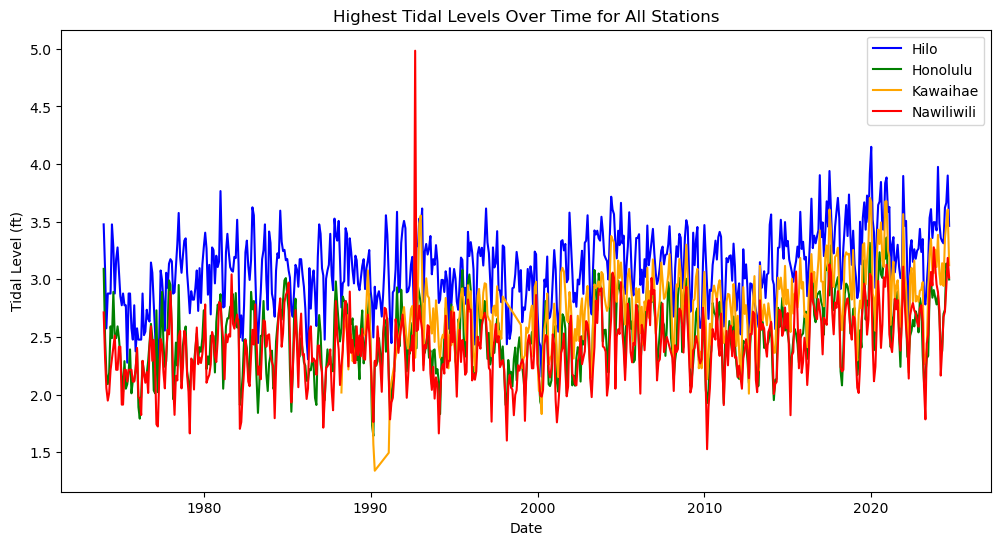

In [99]:

# Plot:'Highest' tidal levels for all datasets over time
plt.figure(figsize=(12, 6))

# Hilo
plt.plot(hilo_df['Date'], hilo_df['Highest'], label='Hilo', color='blue')
# Honolulu
plt.plot(honolulu_df['Date'], honolulu_df['Highest'], label='Honolulu', color='green')
# Kawaihae
plt.plot(kawaihae_df['Date'], kawaihae_df['Highest'], label='Kawaihae', color='orange')
# Nawiliwili
plt.plot(nawiliwili_df['Date'], nawiliwili_df['Highest'], label='Nawiliwili', color='red')

plt.title('Highest Tidal Levels Over Time for All Stations')
plt.xlabel('Date')
plt.ylabel('Tidal Level (ft)')
plt.legend()
plt.show()

### Seasonal Decomposition : Identifying Trends and Seasonality

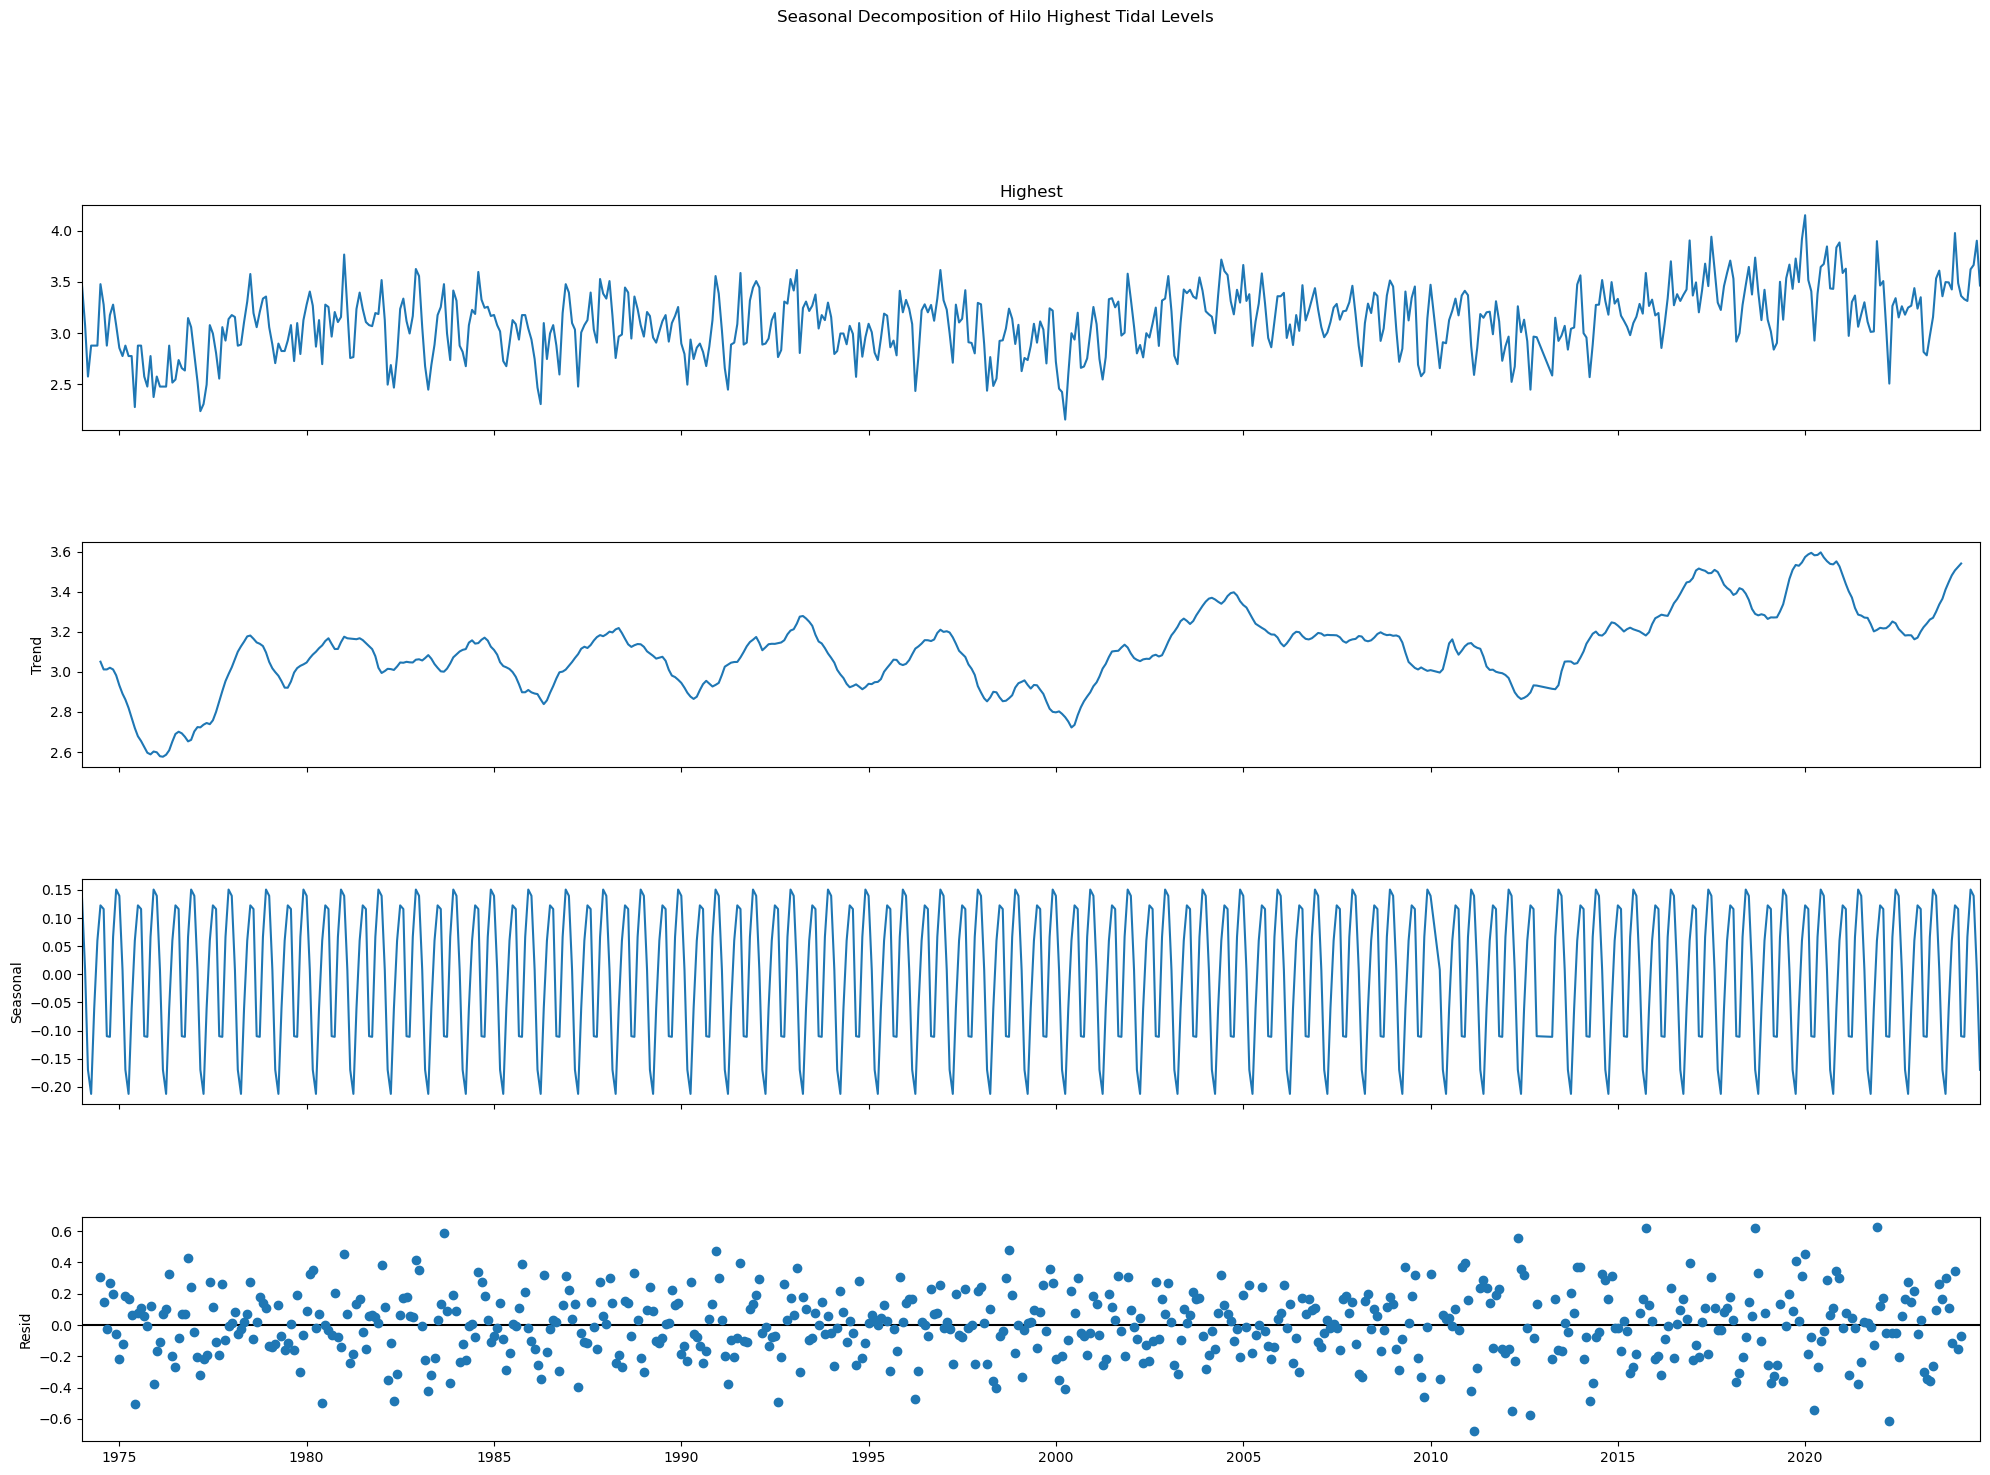

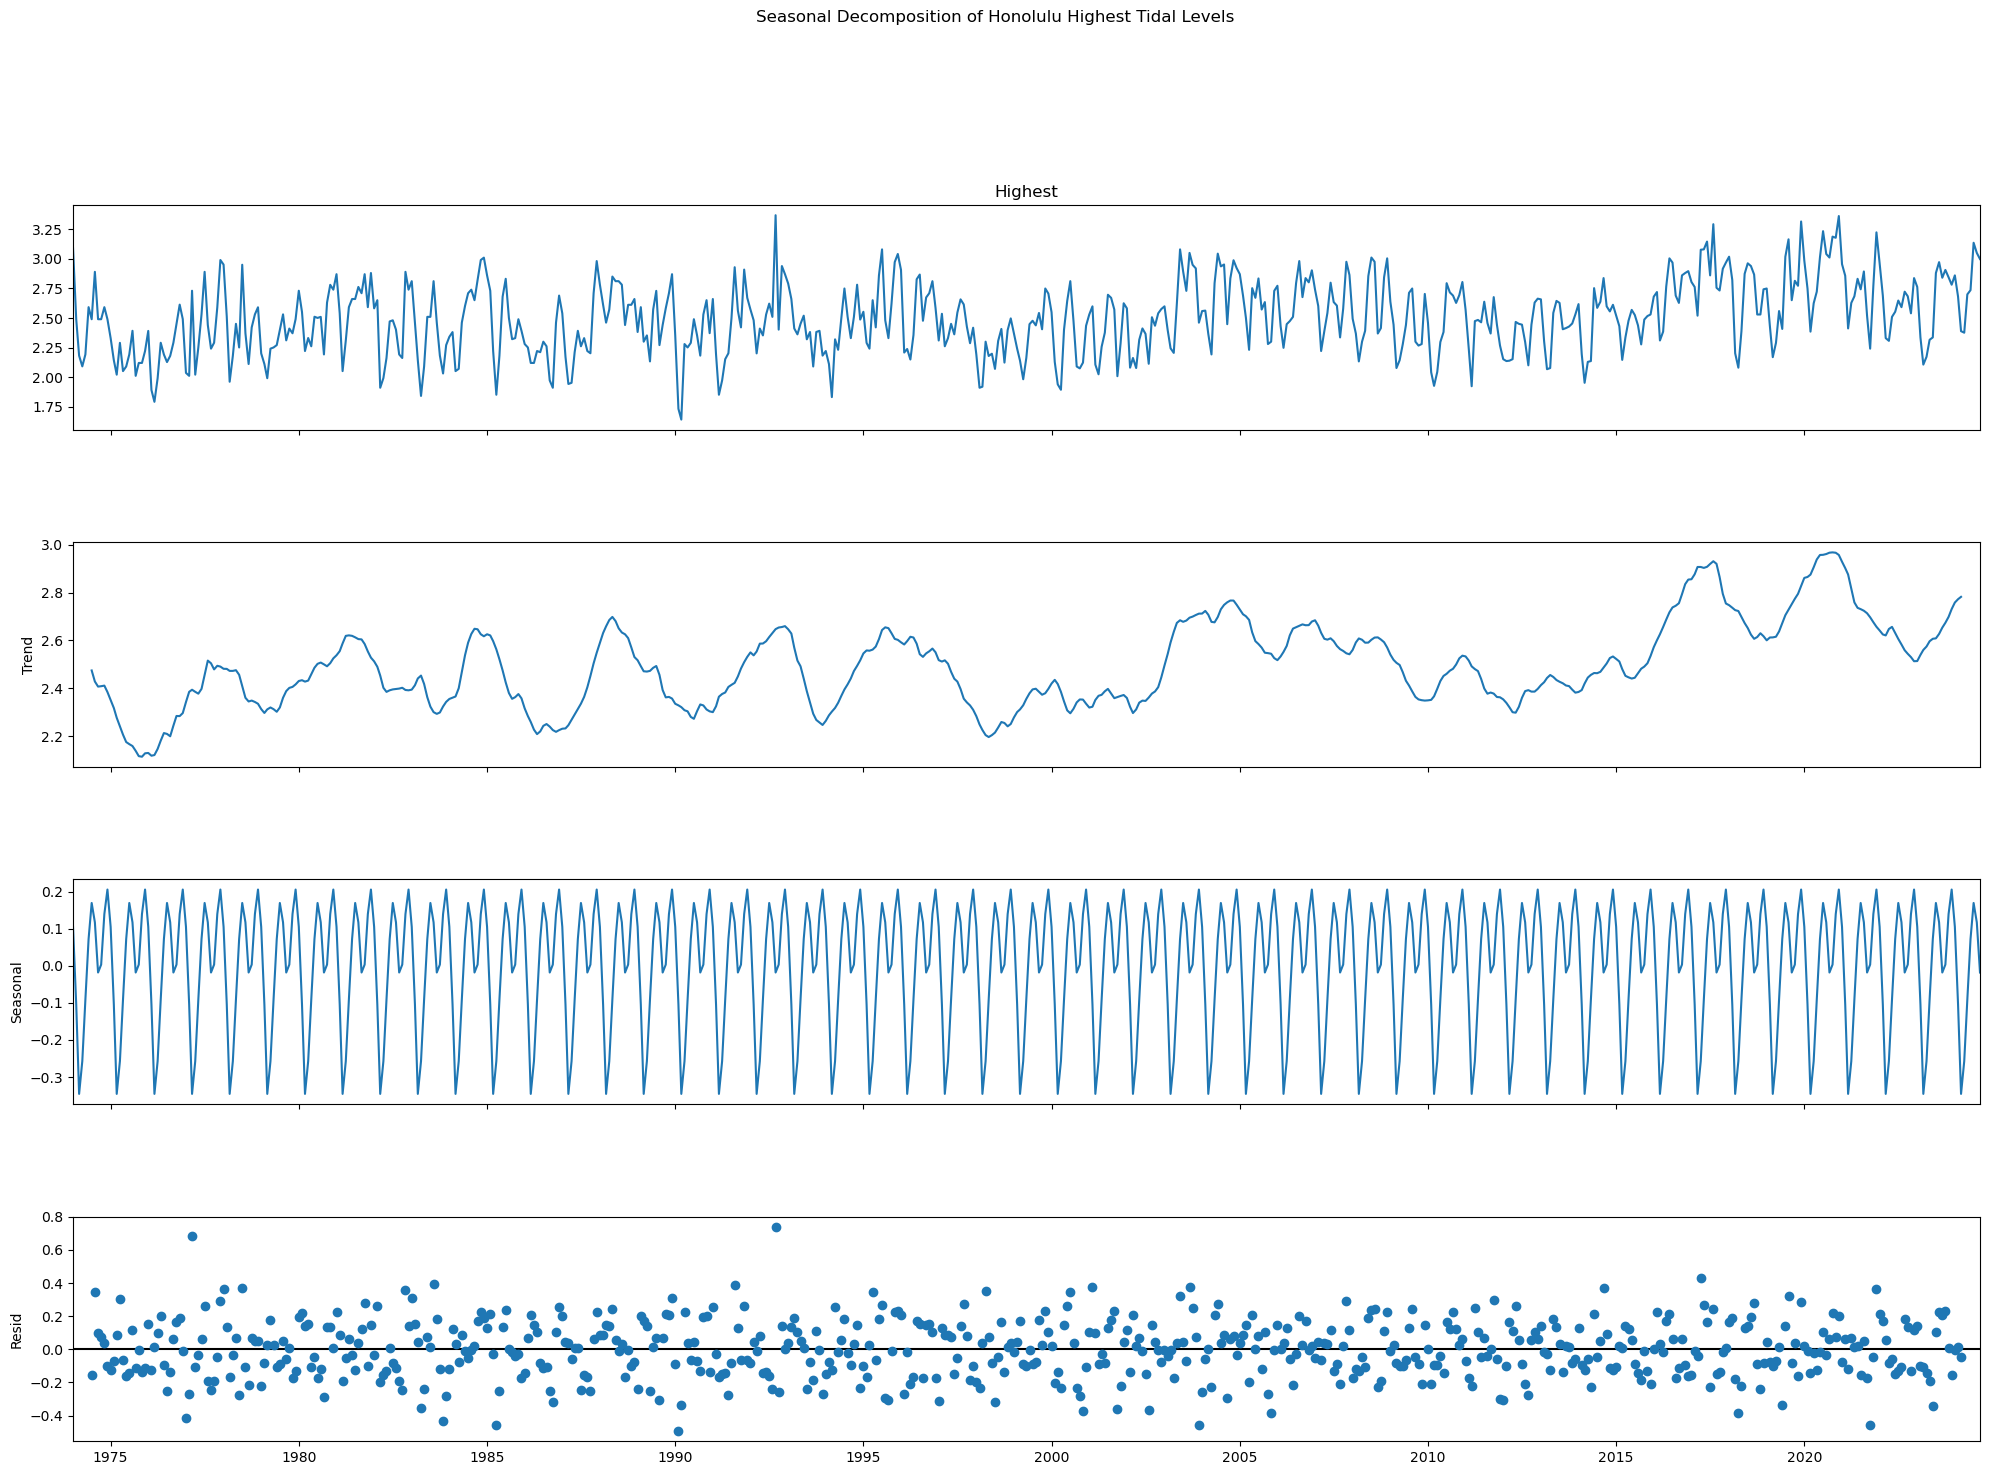

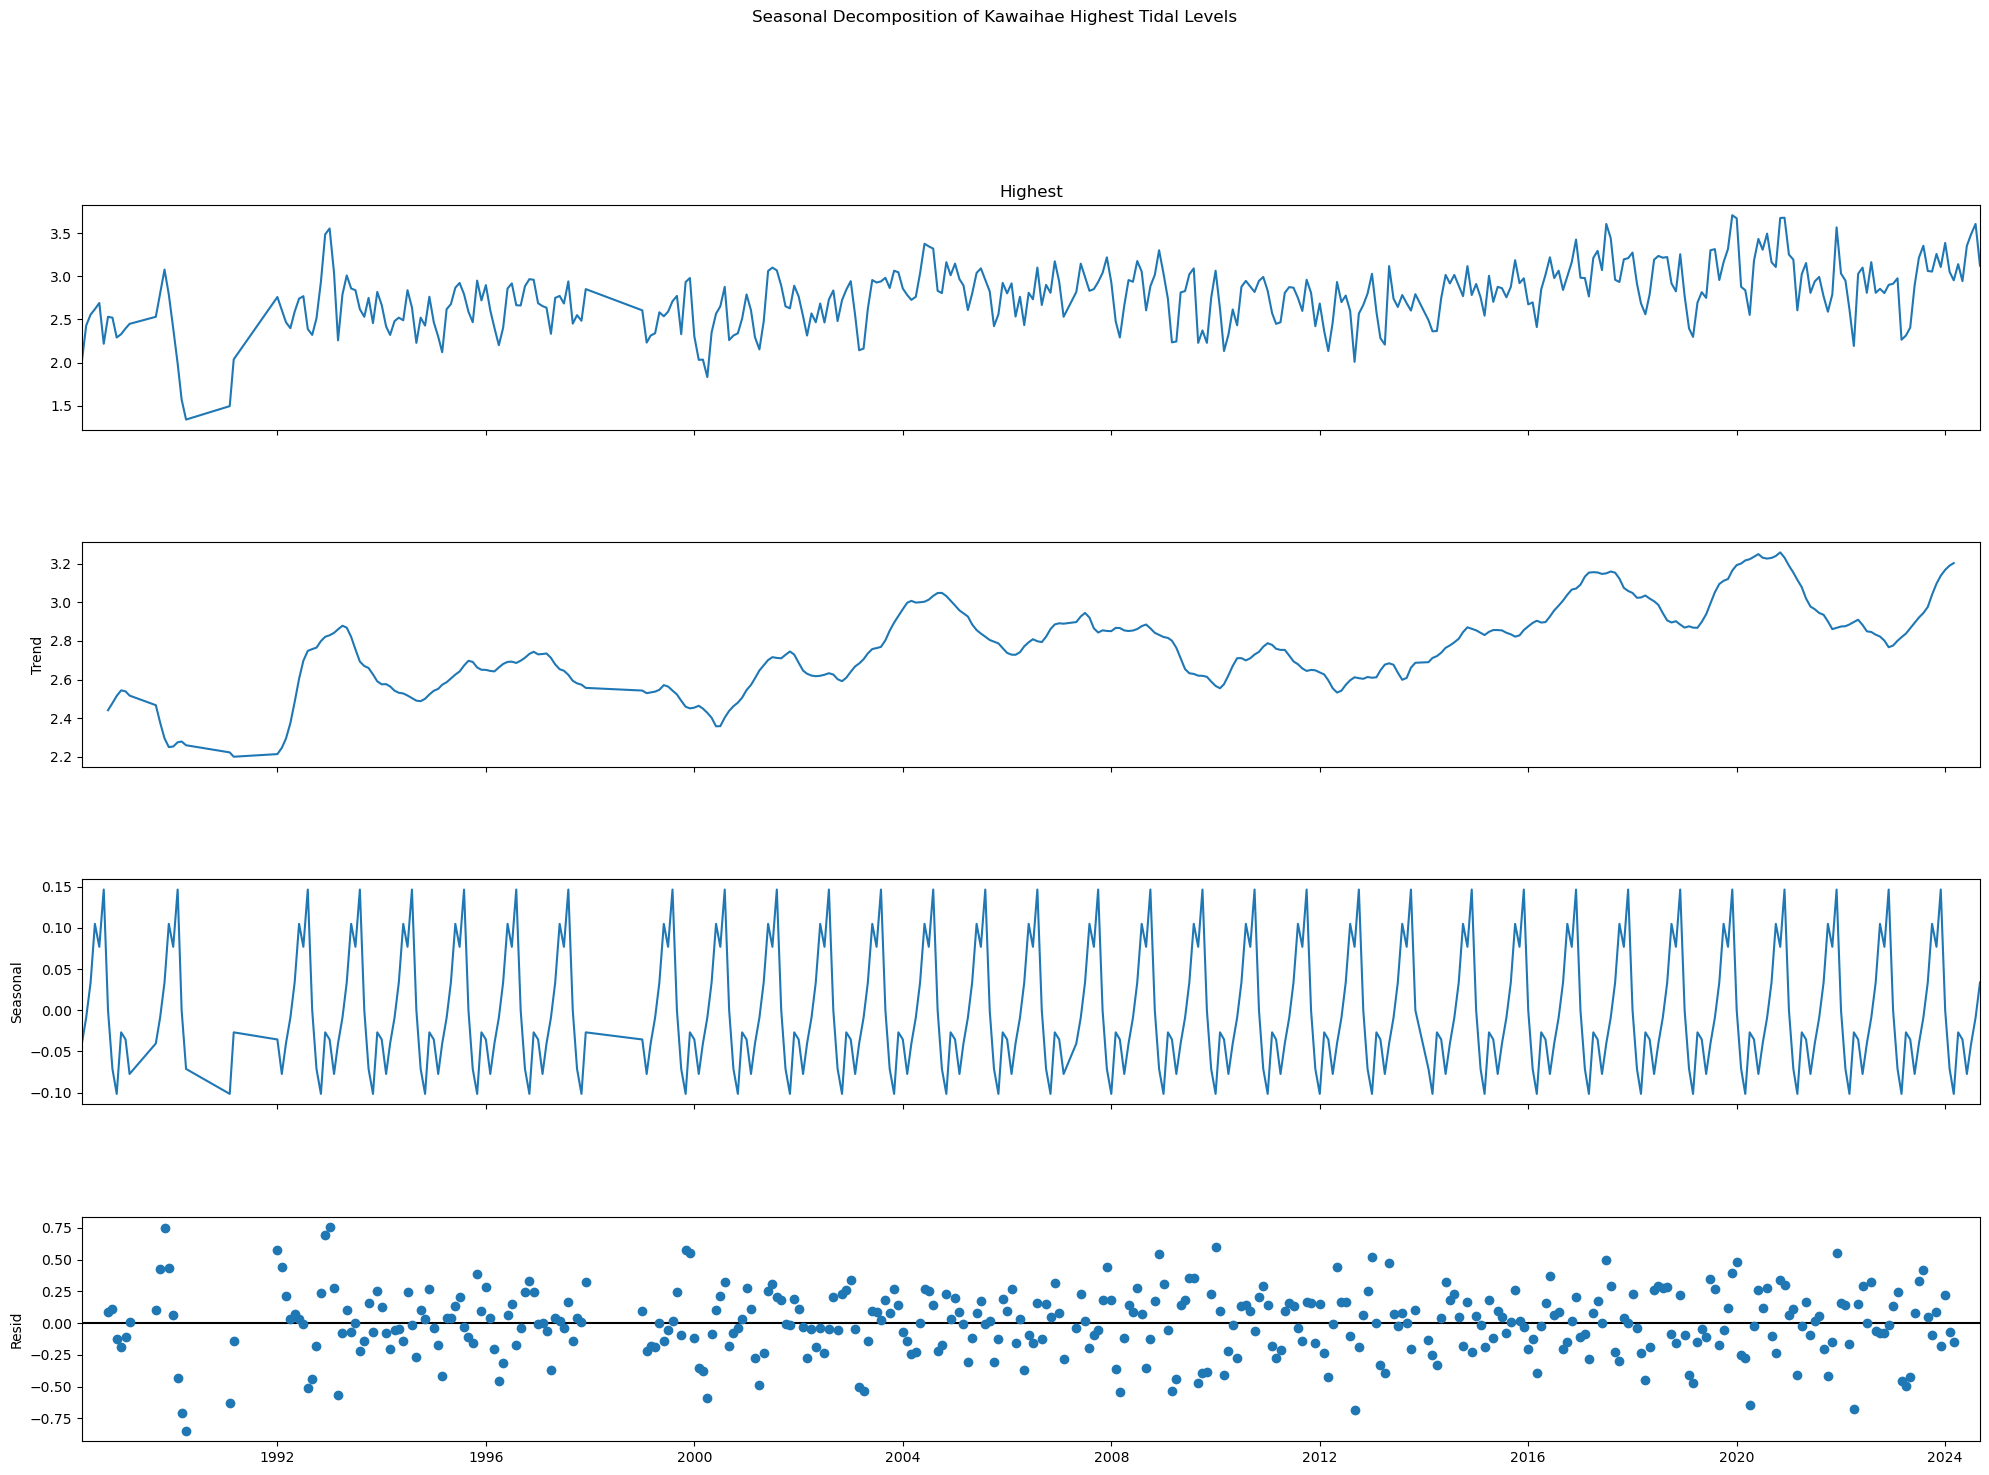

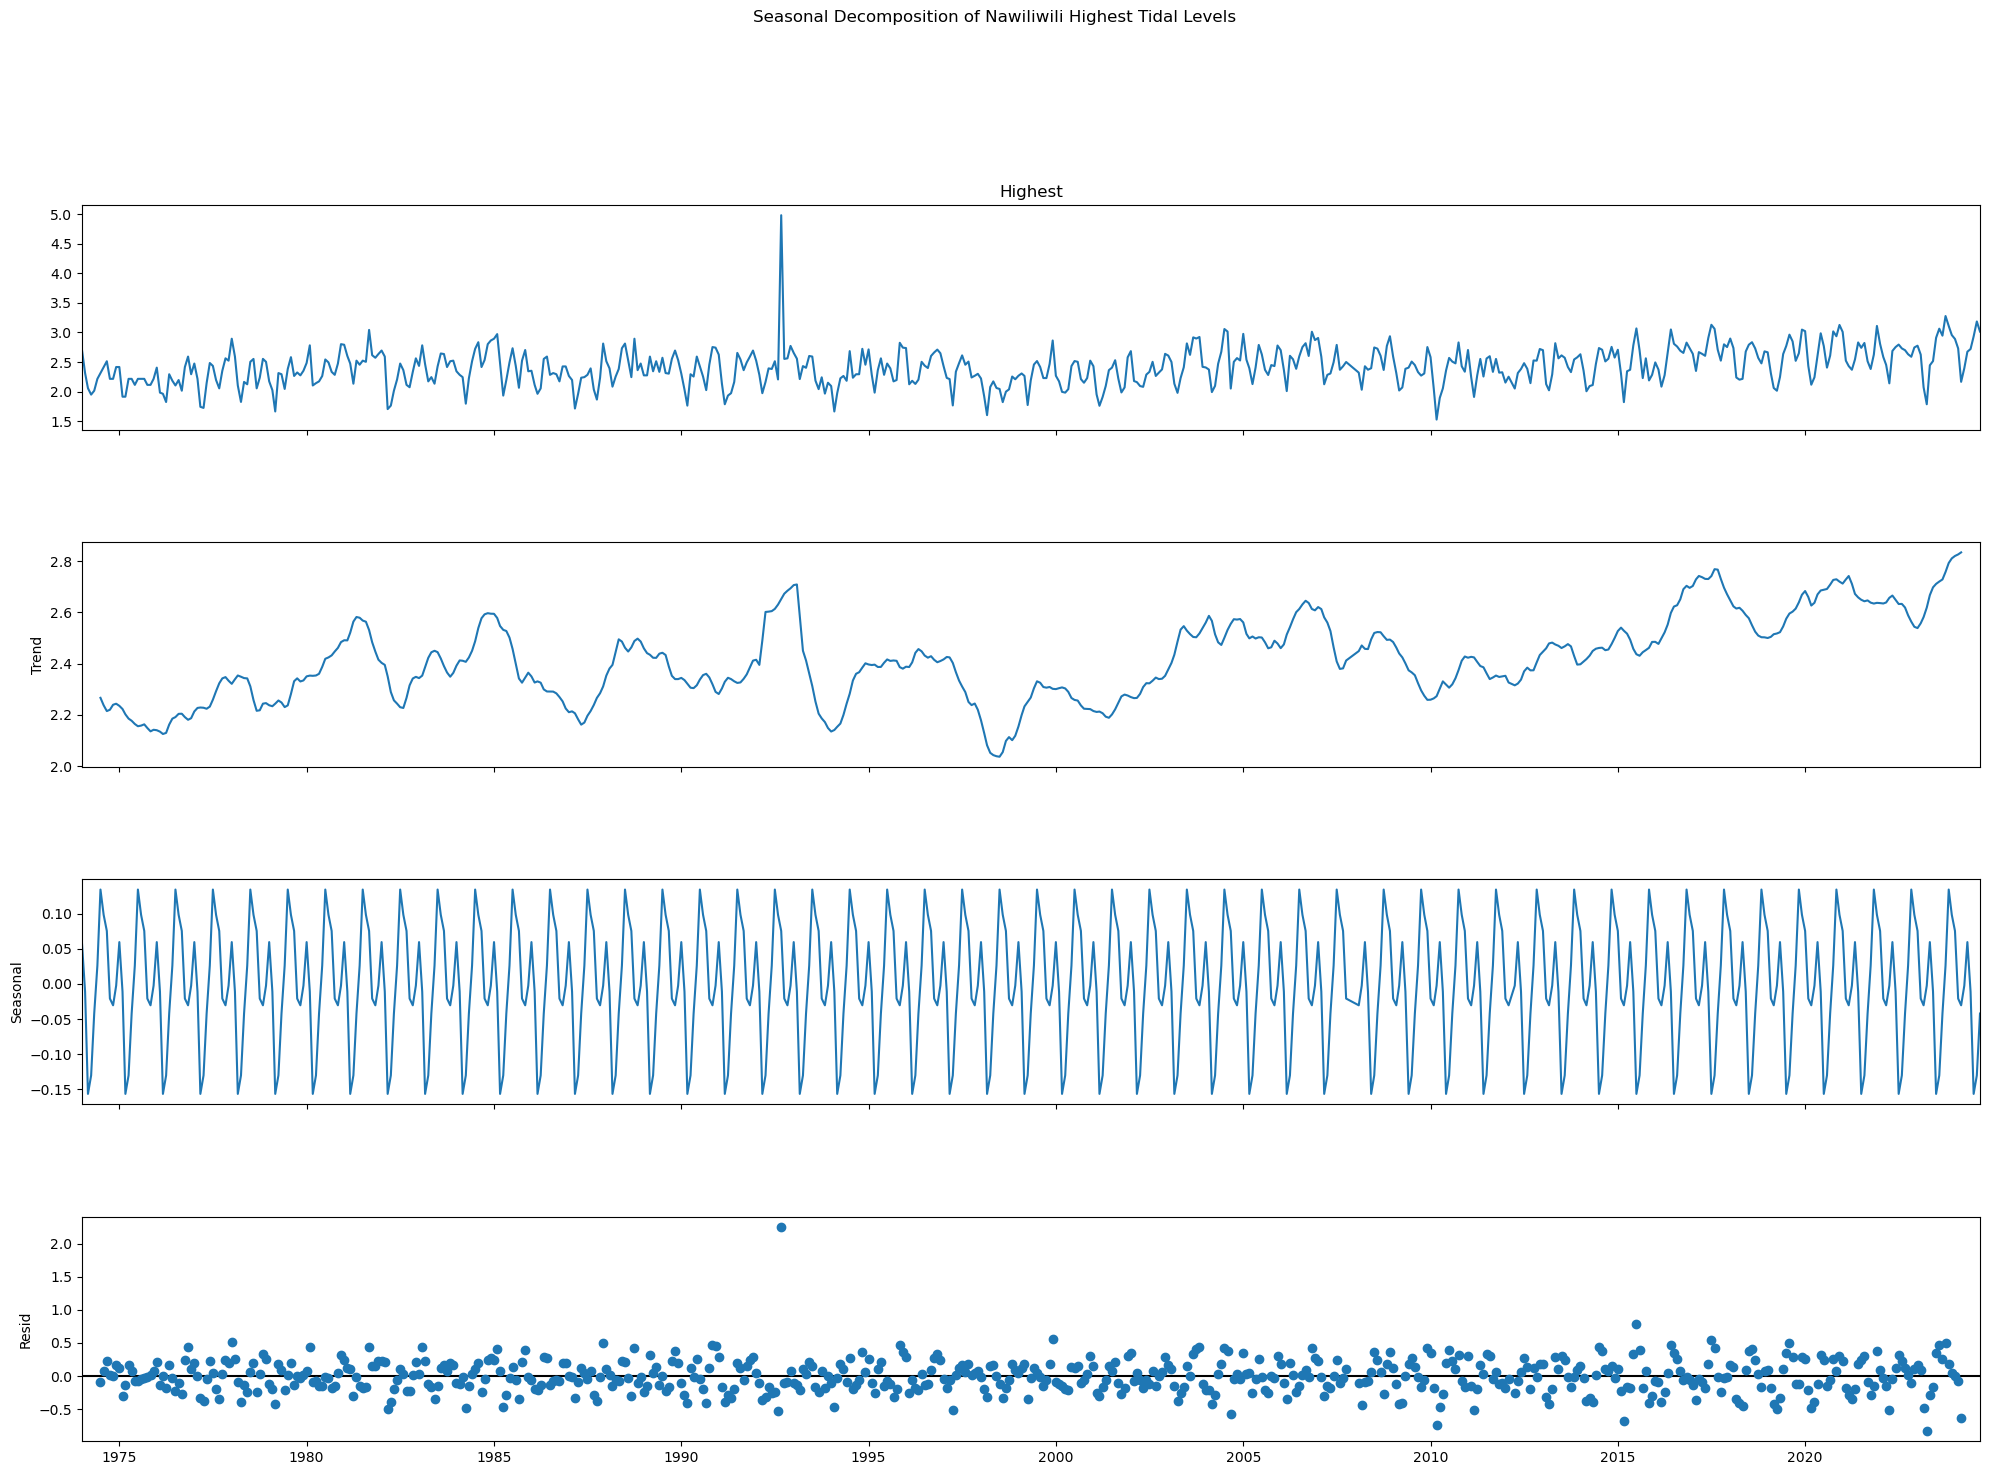

In [102]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 15]

# Decomposing the 'Highest' feature for Hilo dataset
hilo_decomp = seasonal_decompose(hilo_df.set_index('Date')['Highest'], model='additive', period=12)
fig = hilo_decomp.plot()
fig.suptitle('Seasonal Decomposition of Hilo Highest Tidal Levels')

plt.subplots_adjust(hspace=0.5, top=0.85)  
plt.show()

# Decomposing for Honolulu dataset
honolulu_decomp = seasonal_decompose(honolulu_df.set_index('Date')['Highest'], model='additive', period=12)
fig = honolulu_decomp.plot()
fig.suptitle('Seasonal Decomposition of Honolulu Highest Tidal Levels')

plt.subplots_adjust(hspace=0.5, top=0.85)  # Add space at the top and between subplots
plt.show()

# Decomposing for Kawaihae dataset
kawaihae_decomp = seasonal_decompose(kawaihae_df.set_index('Date')['Highest'], model='additive', period=12)
fig = kawaihae_decomp.plot()
fig.suptitle('Seasonal Decomposition of Kawaihae Highest Tidal Levels')

plt.subplots_adjust(hspace=0.5, top=0.85)  # Add space at the top and between subplots
plt.show()

# Decomposing for Nawiliwili dataset
nawiliwili_decomp = seasonal_decompose(nawiliwili_df.set_index('Date')['Highest'], model='additive', period=12)
fig = nawiliwili_decomp.plot()
fig.suptitle('Seasonal Decomposition of Nawiliwili Highest Tidal Levels')


plt.subplots_adjust(hspace=0.5, top=0.85)  
plt.show()




### Understanding Relationships Between Variables

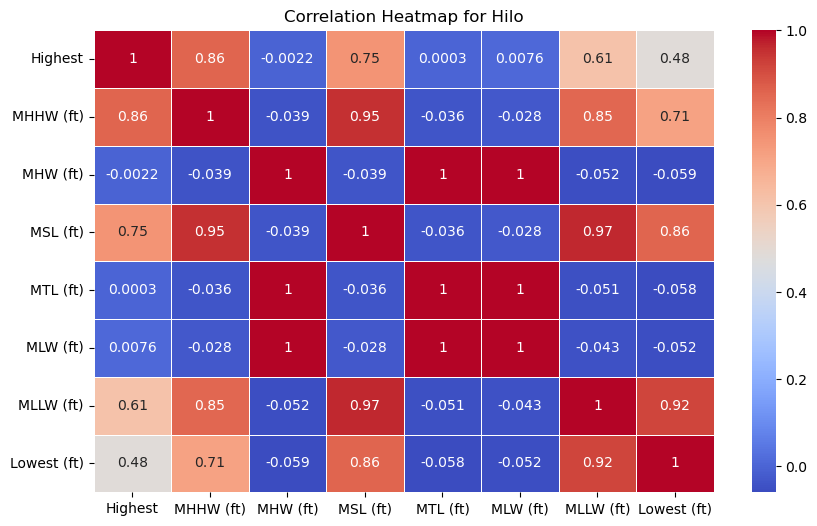

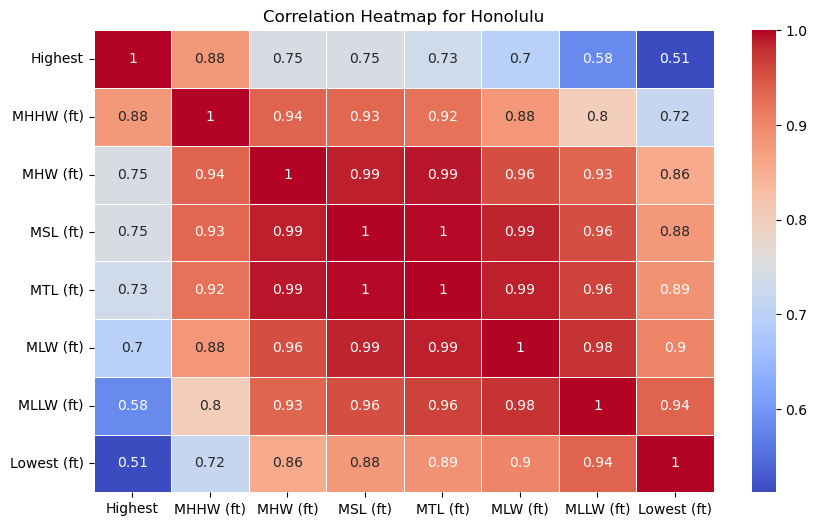

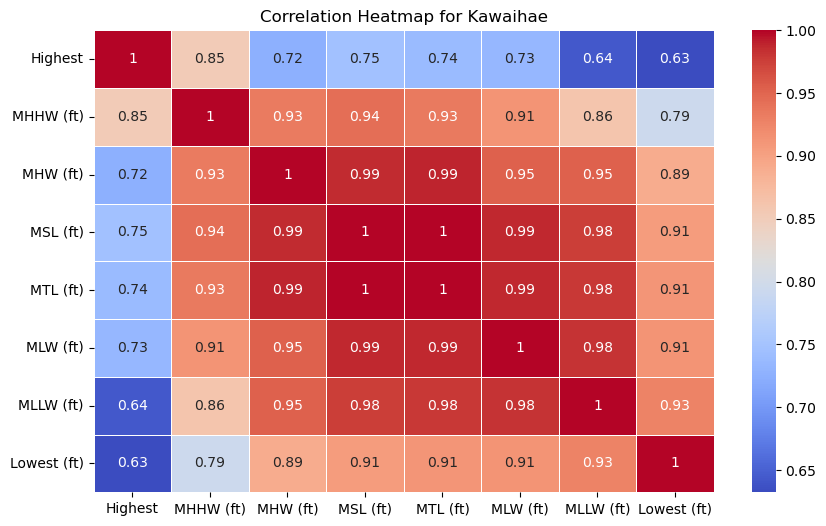

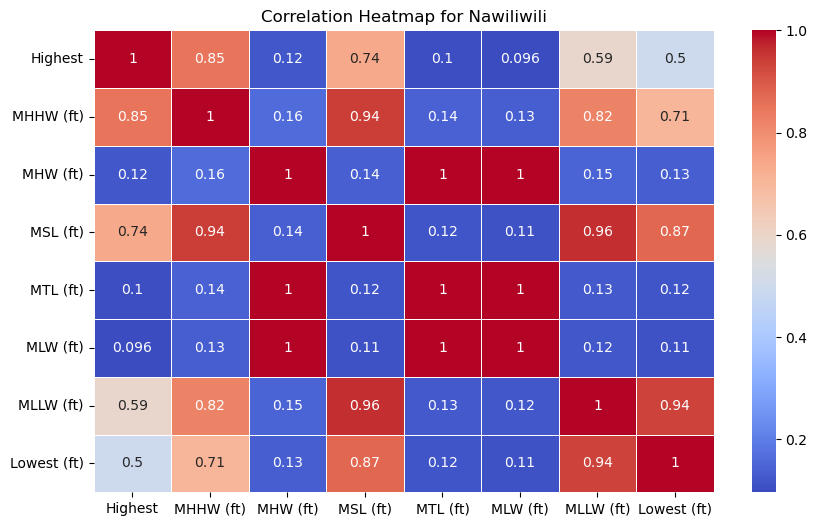

In [104]:
# Figure size
figsize = (10, 6)

# Correlation heatmap for Hilo
plt.figure(figsize=figsize)
sns.heatmap(hilo_df[columns_to_scale].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap for Hilo')
plt.show()

# Correlation heatmap for Honolulu
plt.figure(figsize=figsize)
sns.heatmap(honolulu_df[columns_to_scale].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap for Honolulu')
plt.show()

# Correlation heatmap for Kawaihae
plt.figure(figsize=figsize)
sns.heatmap(kawaihae_df[columns_to_scale].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap for Kawaihae')
plt.show()

# Correlation heatmap for Nawiliwili
plt.figure(figsize=figsize)
sns.heatmap(nawiliwili_df[columns_to_scale].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap for Nawiliwili')
plt.show()


Processing Hilo...
Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0137 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0038 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0038 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0036 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0033 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0035 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0034 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033 - val_loss: 0.0041 - learning_rate: 2.0000e-04
Epoch 10/20
14/14 ━━━━━━━━

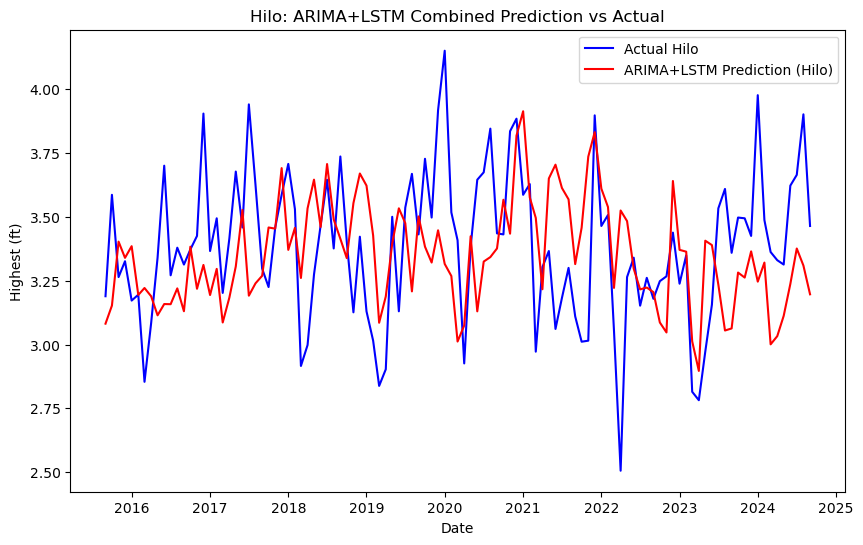


Processing Honolulu...
Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0297 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0037 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0037 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - val_loss: 0.0036 - learning_rate: 2.0000e-04
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039 - val_loss: 0.0036 - learning_rate: 2.0000e-04
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0035 - val_loss: 0.0036 - learning_rate: 2.0000e-04
Epoch 10/20
14/14 

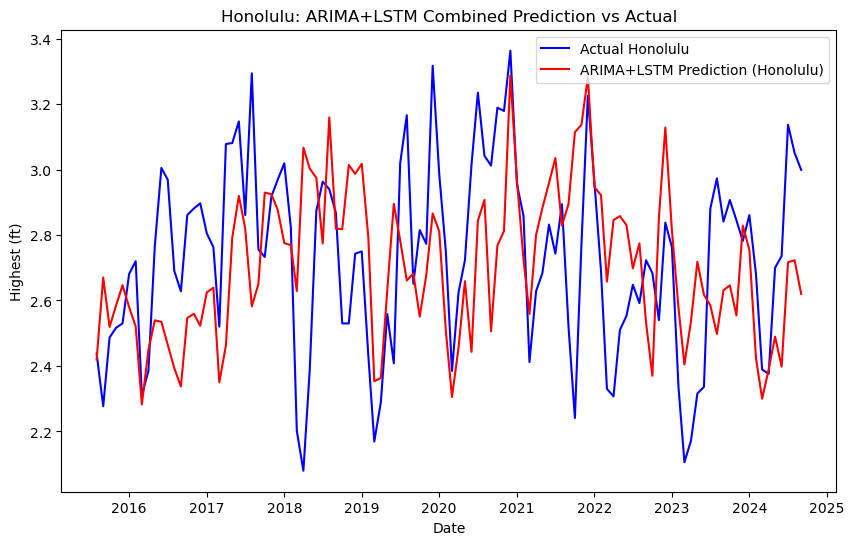


Processing Kawaihae...
Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0421 - val_loss: 0.0179 - learning_rate: 0.0010
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0115 - val_loss: 0.0144 - learning_rate: 0.0010
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0081 - val_loss: 0.0125 - learning_rate: 0.0010
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0081 - val_loss: 0.0125 - learning_rate: 0.0010
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0088 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0079 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0084 - val_loss: 0.0126 - learning_rate: 0.0010
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0076 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0072 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/ste

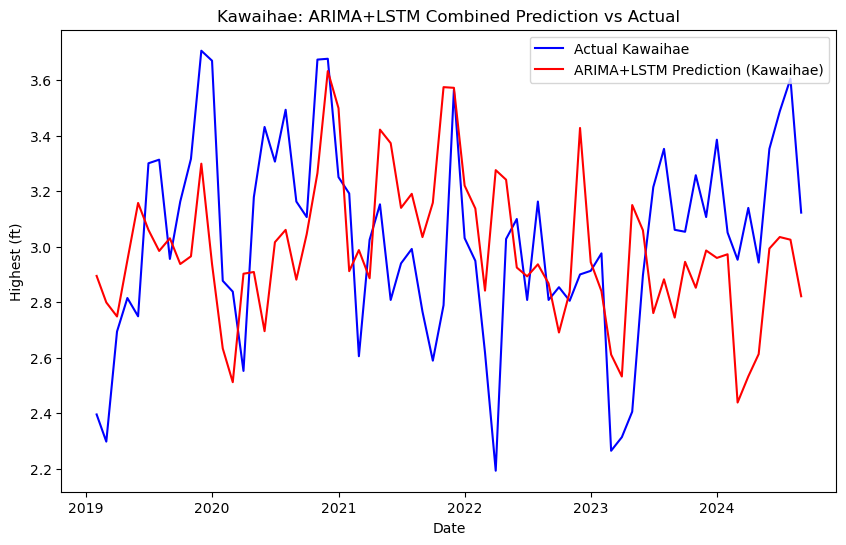


Processing Nawiliwili...
Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0593 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0050 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0051 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0048 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0056 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0047 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0033 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0045 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0053 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 10/20
14/14 ━━━━━━━━━━━━

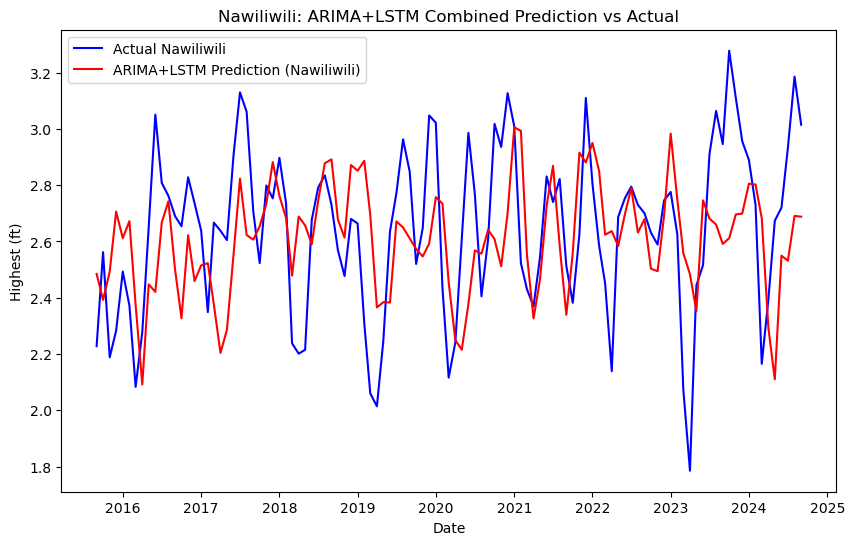

Summary of performance:
Hilo - RMSE: 0.33080472069418804, MAE: 0.26296024160400894
Honolulu - RMSE: 0.31244986959564625, MAE: 0.2541909471344936
Kawaihae - RMSE: 0.3813794706156996, MAE: 0.3186655989098073
Nawiliwili - RMSE: 0.29564700236840696, MAE: 0.24405857127830435


In [108]:
# Convert 'Date' column to datetime format
for df in [hilo_df, honolulu_df, kawaihae_df, nawiliwili_df]:
    df['Date'] = pd.to_datetime(df['Date'])

# Define columns to scale
columns_to_scale = ['Highest', 'MHHW (ft)', 'MHW (ft)', 'MSL (ft)', 
                    'MTL (ft)', 'MLW (ft)', 'MLLW (ft)', 'Lowest (ft)']

# Initialize the scaler
scaler = MinMaxScaler()

# Train: LSTM model with hyperparameter tuning
def train_lstm_model(X_train, y_train, X_test, y_test, lstm_units=50, lr=0.001, batch_size=32, epochs=20):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1)
    )
    # Adam optimizer with learning rate and gradient clipping
    optimizer = Adam(learning_rate=lr, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Early stopping and reduce learning rate callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test),
              callbacks=[early_stopping, reduce_lr])
    
    return model

# Function: Create sequences for LSTM input
def create_sequences(data, time_steps):
    X = []
    y = []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Function: Hybrid ARIMA+LSTM model
def arima_lstm_hybrid(df, feature, station_name, arima_order=(5, 1, 0), time_steps=60, lstm_units=50, lr=0.001):
    print(f"\nProcessing {station_name}...")

    
    arima_model = ARIMA(df[feature], order=arima_order)
    arima_fit = arima_model.fit()
    arima_pred = arima_fit.predict(start=len(df) - len(df) // 5, end=len(df) - 1, typ='levels')

    
    residuals = df[feature] - arima_fit.fittedvalues
    scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

    X, y = create_sequences(scaled_residuals, time_steps)
    
    train_size = int(len(X) * 0.8)
    X_train_residual, X_test_residual = X[:train_size], X[train_size:]
    y_train_residual, y_test_residual = y[:train_size], y[train_size:]
    
    if len(X_test_residual) == 0:
        print("Error: Insufficient test data for LSTM. Skipping this station.")
        return

    # Train LSTM model with fine-tuned parameters
    lstm_model = train_lstm_model(X_train_residual, y_train_residual, X_test_residual, y_test_residual, lstm_units=lstm_units, lr=lr)
    
    
    lstm_residual_pred = lstm_model.predict(X_test_residual)
    lstm_residual_pred = scaler.inverse_transform(lstm_residual_pred)

    combined_pred = arima_pred[:len(lstm_residual_pred)] + lstm_residual_pred.flatten()


    actual_values = df[feature].iloc[-len(combined_pred):]
    rmse = np.sqrt(mean_squared_error(actual_values, combined_pred))
    mae = mean_absolute_error(actual_values, combined_pred)
    
    print(f"{station_name} - RMSE: {rmse}, MAE: {mae}")

    
    plt.figure(figsize=(10, 6))

    # Plot actual values and predicted values with proper Date on x-axis
    plt.plot(df['Date'][-len(combined_pred):], actual_values, label=f'Actual {station_name}', color='blue')
    plt.plot(df['Date'][-len(combined_pred):], combined_pred, label=f'ARIMA+LSTM Prediction ({station_name})', color='red')

    plt.title(f'{station_name}: ARIMA+LSTM Combined Prediction vs Actual')
    plt.xlabel('Date')
    plt.ylabel(f'{feature} (ft)')
    plt.legend()
    plt.show()

    return combined_pred, rmse, mae

# Fine-tuning parameters for each dataset
lstm_units = 50   
learning_rate = 0.001  

# Apply the hybrid model to all four datasets
# For Hilo
combined_pred_hilo, rmse_hilo, mae_hilo = arima_lstm_hybrid(hilo_df, 'Highest', 'Hilo', lstm_units=lstm_units, lr=learning_rate)

# For Honolulu
combined_pred_honolulu, rmse_honolulu, mae_honolulu = arima_lstm_hybrid(honolulu_df, 'Highest', 'Honolulu', lstm_units=lstm_units, lr=learning_rate)

# For Kawaihae
combined_pred_kawaihae, rmse_kawaihae, mae_kawaihae = arima_lstm_hybrid(kawaihae_df, 'Highest', 'Kawaihae', lstm_units=lstm_units, lr=learning_rate)

# For Nawiliwili
combined_pred_nawiliwili, rmse_nawiliwili, mae_nawiliwili = arima_lstm_hybrid(nawiliwili_df, 'Highest', 'Nawiliwili', lstm_units=lstm_units, lr=learning_rate)

# Summary of performance
print(f"Summary of performance:\n"
      f"Hilo - RMSE: {rmse_hilo}, MAE: {mae_hilo}\n"
      f"Honolulu - RMSE: {rmse_honolulu}, MAE: {mae_honolulu}\n"
      f"Kawaihae - RMSE: {rmse_kawaihae}, MAE: {mae_kawaihae}\n"
      f"Nawiliwili - RMSE: {rmse_nawiliwili}, MAE: {mae_nawiliwili}")


## Model: Arima+LSTM Hybrid Model
The ARIMA+LSTM hybrid model was chosen for forecasting tidal levels due to its ability to address both linear and seasonal components (via ARIMA) and complex, non-linear patterns (via LSTM). This combination is especially suitable for time series data such as tidal levels, which exhibit predictable periodic factors (e.g., lunar cycles) alongside irregular influences from factors like weather anomalies. The hybrid approach allows ARIMA to capture the seasonal trends or “periodicity” in the data, while LSTM compensates for residuals—those non-linear, unpredictable fluctuations that ARIMA alone might miss. By addressing both cyclic and residual (unexplained) variability, this dual-method approach achieves relatively low RMSE and MAE values across stations, indicating improved forecast accuracy and reduced prediction errors.
The model’s versatility across varied datasets is demonstrated by its adaptability to each station’s unique tidal characteristics, making it applicable for a range of tidal environments. The reliable tidal forecasts produced by this hybrid model are invaluable for coastal management, providing critical insights that support decision-making in areas such as coastal infrastructure planning, erosion control, and disaster preparedness. These are essential elements of geoscientific applications, where understanding and mitigating coastal impacts are paramount.

## Analysis of each Stations:
### Hilo:
#### Performance: 0.3308, MAE: 0.2629
The model achieved a good fit for Hilo, with relatively low RMSE and MAE values indicating strong accuracy. The ARIMA component effectively captured Hilo’s seasonal patterns, which are influenced by lunar cycles and periodic oceanic patterns. Meanwhile, the LSTM model handled the finer details in residuals, particularly during high-tide events where variability is most pronounced. Hilo’s tidal data often reflects significant variability due to both oceanic currents and sporadic weather events. The hybrid model’s ability to handle these fluctuations suggests that it can serve as a valuable tool for monitoring Hilo’s coastal dynamics and predicting extreme tidal events, which are critical for coastal safety and planning.

### Honolulu:
#### Performance: RMSE: 0.3124, MAE: 0.2541
Honolulu's slightly lower RMSE and MAE values, compared to Hilo, indicate a strong model fit. Honolulu’s tidal patterns are relatively stable, allowing ARIMA to model the periodicity with high accuracy, while LSTM refines predictions by addressing minor residual variations. This stability implies a lower impact of non-periodic, erratic influences. The model’s high accuracy in Honolulu suggests that it is well-suited for long-term tidal behavior studies in regions with relatively stable tidal fluctuations. This reliable prediction capability is essential for planning and managing infrastructure that depends on consistent tidal forecasts.

### Kawaihae:
#### Performance: RMSE: 0.3813, MAE: 0.3186
Kawaihae presented a greater challenge for the model, as indicated by the higher RMSE and MAE. This suggests that while the ARIMA component captured the primary seasonal trend, there may be unique or less predictable patterns in Kawaihae’s tidal data that are challenging to model, even with LSTM’s support for residuals. Kawaihae’s coastal environment might be influenced by specific geographic or oceanographic factors, such as irregular wave patterns, localized currents, or wind effects, which contribute to the observed variability. Although the hybrid model provided a reasonable fit, further tuning or the inclusion of additional exogenous variables—such as wind speed, atmospheric pressure, or nearby currents—could potentially enhance its performance. This refinement could be particularly valuable for geoscientific applications focusing on localized tidal impact studies in areas with unique environmental characteristics.

### Nawiliwili:
#### Performance: RMSE: 0.2956, MAE: 0.2440
Nawiliwili achieved the lowest RMSE and MAE among the stations, reflecting an excellent fit. Nawiliwili’s tidal behavior is relatively consistent, allowing the ARIMA model to accurately capture periodic cycles. The LSTM component further refines predictions by accounting for minor residuals. This model’s high accuracy in Nawiliwili suggests a strong understanding of the station’s tidal influences, which are likely driven by stable periodic factors with minimal interference from unpredictable environmental factors. For geoscientists, this means that the model can be used reliably in long-term planning and forecasting, supporting tasks such as infrastructure development, environmental impact assessments, and coastal hazard mitigation.


Processing forecast for Hilo...


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


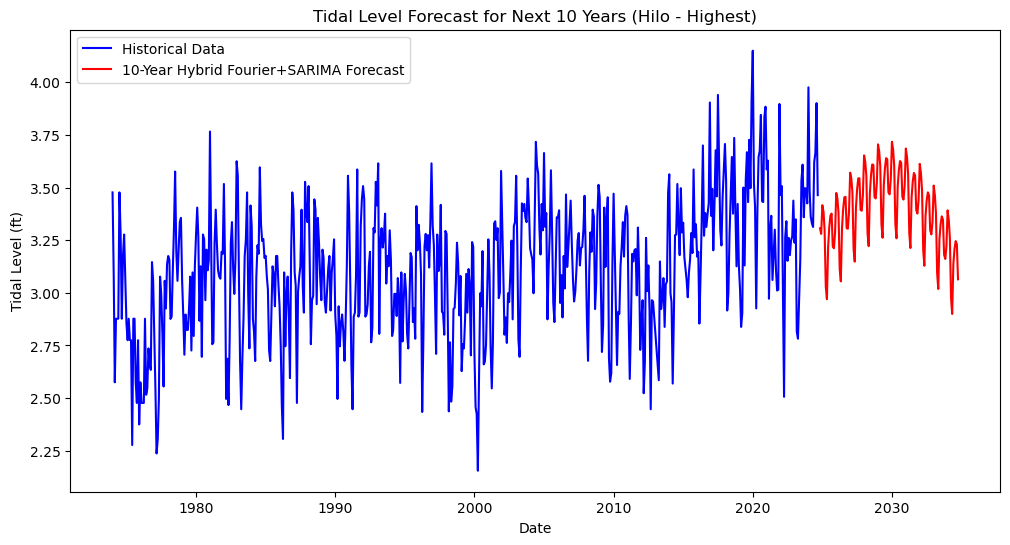


Processing forecast for Honolulu...


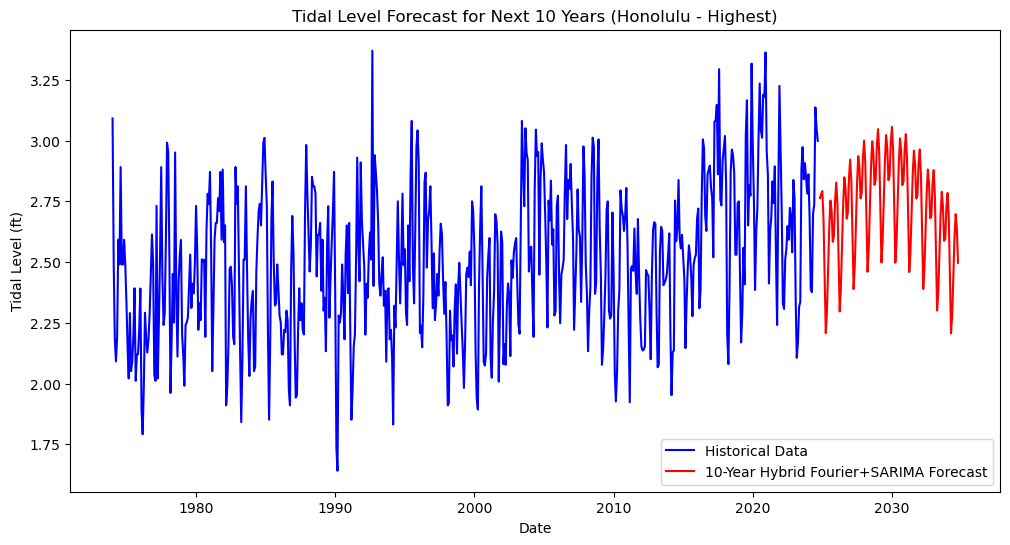


Processing forecast for Kawaihae...


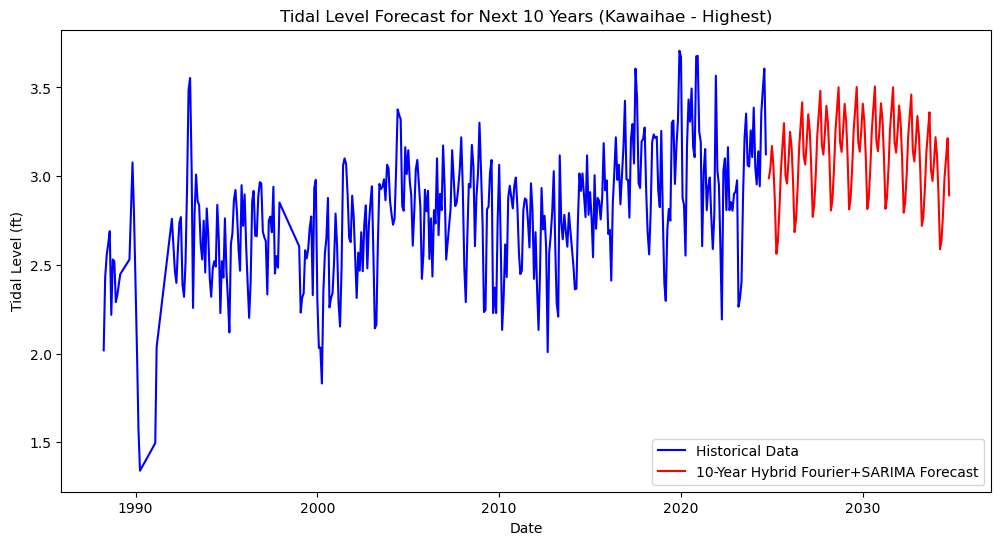


Processing forecast for Nawiliwili...


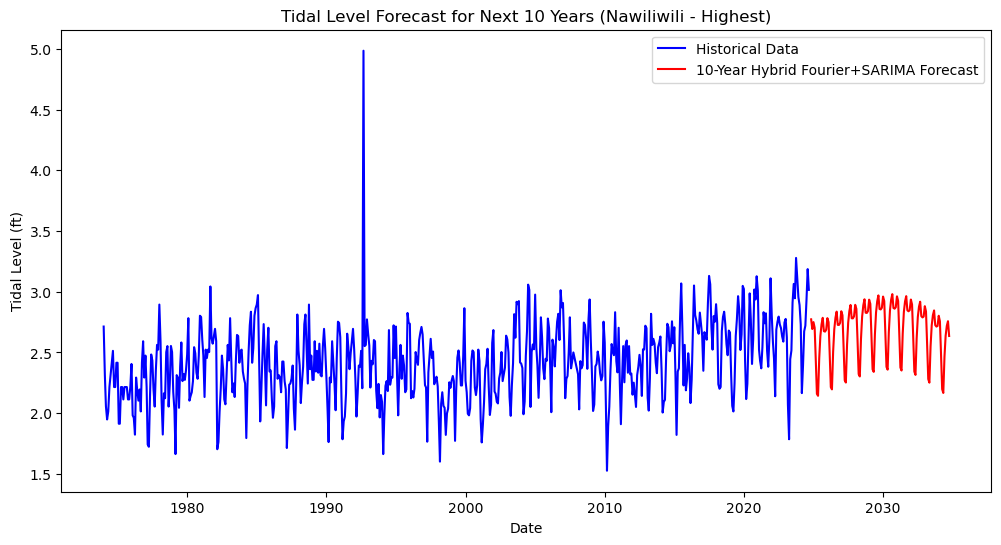


Forecast for Hilo for the next 10 years:
2024-10: 3.31 ft
2024-11: 3.28 ft
2024-12: 3.42 ft
2025-01: 3.38 ft
2025-02: 3.30 ft
2025-03: 3.03 ft
2025-04: 2.97 ft
2025-05: 3.22 ft
2025-06: 3.31 ft
2025-07: 3.37 ft
2025-08: 3.38 ft
2025-09: 3.22 ft
2025-10: 3.21 ft
2025-11: 3.29 ft
2025-12: 3.47 ft
2026-01: 3.45 ft
2026-02: 3.38 ft
2026-03: 3.11 ft
2026-04: 3.05 ft
2026-05: 3.31 ft
2026-06: 3.40 ft
2026-07: 3.45 ft
2026-08: 3.46 ft
2026-09: 3.31 ft
2026-10: 3.30 ft
2026-11: 3.38 ft
2026-12: 3.57 ft
2027-01: 3.54 ft
2027-02: 3.48 ft
2027-03: 3.21 ft
2027-04: 3.15 ft
2027-05: 3.40 ft
2027-06: 3.49 ft
2027-07: 3.54 ft
2027-08: 3.54 ft
2027-09: 3.39 ft
2027-10: 3.39 ft
2027-11: 3.47 ft
2027-12: 3.65 ft
2028-01: 3.62 ft
2028-02: 3.55 ft
2028-03: 3.28 ft
2028-04: 3.22 ft
2028-05: 3.47 ft
2028-06: 3.56 ft
2028-07: 3.61 ft
2028-08: 3.61 ft
2028-09: 3.45 ft
2028-10: 3.45 ft
2028-11: 3.52 ft
2028-12: 3.71 ft
2029-01: 3.67 ft
2029-02: 3.60 ft
2029-03: 3.33 ft
2029-04: 3.26 ft
2029-05: 3.51 ft
2029-0

In [111]:

# Fitting Fourier series to data
def fit_fourier_series(data, num_terms=5):
    n = len(data)
    t = np.arange(n)
    terms = [np.ones(n)]  # Start with a constant term of ones with the same length as data
    for k in range(1, num_terms + 1):
        terms.append(np.cos(2 * np.pi * k * t / n))
        terms.append(np.sin(2 * np.pi * k * t / n))

    terms = np.column_stack(terms)
    
    
    coefficients = np.linalg.lstsq(terms, data, rcond=None)[0]
    return np.dot(terms, coefficients)


def fit_sarima_residuals(data, seasonal_order=(1, 1, 1, 12)):
    model = SARIMAX(data, order=(1, 1, 1), seasonal_order=seasonal_order)
    return model.fit(disp=False)


forecast_length = 120  # Forecasting for the next 10 years (120 months)


stations = [
    {'name': 'Hilo', 'df': hilo_df},
    {'name': 'Honolulu', 'df': honolulu_df},
    {'name': 'Kawaihae', 'df': kawaihae_df},
    {'name': 'Nawiliwili', 'df': nawiliwili_df}
]


station_forecasts = {}

# Looping through each station and apply the Fourier + SARIMA model
for station in stations:
    station_name = station['name']
    df = station['df']
    tidal_data = df['Highest']  

    print(f"\nProcessing forecast for {station_name}...")

    # Fourier series component
    fourier_component = fit_fourier_series(tidal_data, num_terms=5)


    residuals = tidal_data - fourier_component

    # SARIMA model on residuals
    sarima_model = fit_sarima_residuals(residuals)
    sarima_forecast = sarima_model.get_forecast(steps=forecast_length).predicted_mean

    # Combining Fourier and SARIMA forecasts
    combined_forecast = fourier_component[-forecast_length:] + sarima_forecast

    # Store predictions and calculate forecast dates
    forecast_dates = pd.date_range(start=df['Date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_length, freq='M')
    station_forecasts[station_name] = (forecast_dates, combined_forecast)


    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], tidal_data, label="Historical Data", color='blue')
    plt.plot(forecast_dates, combined_forecast, label="10-Year Hybrid Fourier+SARIMA Forecast", color='red')
    plt.title(f"Tidal Level Forecast for Next 10 Years ({station_name} - Highest)")
    plt.xlabel("Date")
    plt.ylabel("Tidal Level (ft)")
    plt.legend()
    plt.show()


for station_name, (dates, forecast) in station_forecasts.items():
    print(f"\nForecast for {station_name} for the next 10 years:")
    for date, value in zip(dates, forecast):
        print(f"{date.strftime('%Y-%m')}: {value:.2f} ft")


## Model: Hybrid Fourier + SARIMA Model
The Hybrid Fourier + SARIMA model was selected to forecast tidal levels over the next 10 years by leveraging its ability to capture cyclical patterns inherent in tidal data and manage irregular residual patterns. Since tidal behavior typically exhibits seasonal fluctuations and periodicity, Fourier series is particularly effective in modeling these repeating cycles. The SARIMA component complements this by capturing irregular variations that Fourier cannot account for, such as short-term anomalies within the tidal data itself. This captures the underlying periodic trends in tidal levels, reflecting the general patterns of high and low tides over time. Although we're not explicitly incorporating lunar or solar data, the Fourier component is well-suited to represent the cyclical nature of tides purely based on observed historical data.By applying SARIMA to the residuals from the Fourier series, the model addresses short-term, unpredictable fluctuations within the tidal data, refining the forecast to account for anomalies and ensuring accuracy beyond basic seasonal patterns. Using Fourier for cyclic patterns and SARIMA for residual noise ensures the model remains accurate and stable over a 10-year period, capturing both the predictable and unpredictable elements within tidal data. This hybrid model adapts to each station’s unique tidal data characteristics by adjusting the Fourier series terms and refining with SARIMA. This makes it suitable for different geographic and environmental settings without needing explicit exogenous factors like lunar phases. With accurate, station-specific tidal forecasts, this model provides essential information for infrastructure planning, coastal erosion management, and flood preparedness, which are critical for geoscience applications focused on understanding and mitigating tidal impacts.



## Station-Specific Analysis 
### Hilo:
Hilo’s forecasted tidal levels exhibit substantial variability, with periodic peaks and troughs. This pattern aligns with Hilo’s dynamic coastal environment, influenced by its geographic position and potentially subject to stronger oceanic currents and weather impacts. For Hilo, the pronounced tidal fluctuations underscore the importance of resilient coastal infrastructure. These forecasts are essential for preparing for high tide events and managing erosion risks, particularly in sensitive areas that could be vulnerable to sea-level rise or extreme weather.

The Fourier component effectively captured the periodic tidal cycles, while SARIMA refined the model to handle the residual, non-cyclic fluctuations. This combination yielded an accurate long-term forecast for Hilo, balancing regular tidal changes with short-term irregularities.The model's ability to predict Hilo's complex tidal behavior demonstrates the power of combining Fourier analysis for capturing periodicity with SARIMA for addressing residual patterns. The forecast for Hilo is expected to be highly reliable, particularly useful for trend analysis and anomaly detection in tidal studies.


### Honolulu:
 Honolulu’s tidal forecast shows a relatively stable pattern with less extreme fluctuations than Hilo. The smoother tidal levels suggest that Honolulu’s tidal behavior may be more consistent, possibly due to fewer environmental disturbances or a more protected coastal geography. Honolulu's predictable tidal forecast supports stable planning for long-term infrastructure projects. This stability suggests fewer emergency interventions for extreme tidal events, allowing for cost-effective, consistent maintenance and preparation strategies.

For Honolulu, the Fourier component captured the consistent periodic cycles well, and SARIMA helped to refine minor residuals. The model’s performance here demonstrates that it can reliably forecast for stations with more regular tidal patterns. The low variability in the residuals indicates that the model is highly tuned for Honolulu’s dataset, as fewer adjustments were required by the SARIMA component. This stability in the forecast enhances the model’s applicability for extended projections and gives confidence in Honolulu's tidal predictions over a long horizon.

### Kawaihae: 
Kawaihae’s forecast displays moderate tidal variability, reflecting a mix of stable cycles with occasional anomalies. This variability could be influenced by local coastal features or intermediate weather impacts. The forecast suggests that while Kawaihae generally follows a predictable tidal cycle, occasional fluctuations could necessitate adaptive management strategies. Coastal planners could leverage these insights to prepare for periodic events while maintaining flexibility for unexpected tidal shifts.

For Kawaihae, the Fourier component captured the primary cycles well, but SARIMA was necessary to adjust for more irregular residuals than in Honolulu. This highlights the importance of the SARIMA component for stations with less stable periodicity.The model’s performance for Kawaihae demonstrates its adaptability to mid-variability stations, where tidal behavior isn’t as stable as Honolulu but not as volatile as Hilo. The hybrid model’s balanced approach provides confidence in medium-term predictions, though further adjustments may improve accuracy for long-term applications.

### Nawiliwili
Nawiliwili’s forecast shows moderate tidal changes, with relatively predictable cycles punctuated by minor variations. This pattern suggests a stable tidal environment, likely due to Nawiliwili’s coastal configuration and reduced exposure to extreme tidal drivers. Nawiliwili’s forecast supports stable, long-term coastal planning. The low variation in predicted tidal levels suggests that Nawiliwili can rely on consistent preparation strategies, with fewer interventions required for unexpected tidal events. This stability is advantageous for minimizing coastal infrastructure costs and focusing on sustained environmental conservation.

The Fourier series effectively modeled Nawiliwili’s stable cycles, and SARIMA adjustments were minimal, similar to Honolulu’s. This suggests that the model can reliably capture consistent periodic data with minor modifications, making it suitable for less volatile tidal patterns.T he forecast for Nawiliwili benefits from minimal residual adjustments, indicating that the model’s default parameters are highly suited to this station’s data characteristics. This strengthens confidence in the forecast’s applicability for long-term planning and makes Nawiliwili an ideal case for the hybrid model’s strengths in stable environments.




### RESULTS: Highest predicted tide level for each year at each station

#### Hilo

- 2024: 3.42 ft (December)
- 2025: 3.47 ft (December)
- 2026: 3.57 ft (December)
- 2027: 3.65 ft (December)
- 2028: 3.71 ft (December)
- 2029: 3.72 ft (December)
- 2030: 3.69 ft (December)
- 2031: 3.64 ft (January)
- 2032: 3.57 ft (January)
- 2033: 3.46 ft (January)
- 2034: 3.35 ft (January)
- 
The highest tides in Hilo are forecasted primarily during winter months (December & January), with significant peaks expected in 2028 and 2029. This pattern may require close monitoring during these months, especially for properties and infrastructure situated near the coastline. With recurring high tides near or above 3.5 ft, Hilo may face increased risks of coastal erosion, flooding, and potential damage to infrastructure. Investments in seawalls, beach nourishment, and other erosion control measures are recommended. For years with exceptionally high tides (2028 and 2029), emergency preparedness measures, such as temporary barriers and flood alerts, should be prioritized. Evacuation protocols may also need to be refined to address potential extreme events.


#### Honolulu 
- 2025: 2.83 ft (December)
- 2026: 2.92 ft (December)
- 2027: 3.00 ft (December)
- 2028: 3.05 ft (December)
- 2029: 3.06 ft (December)
- 2030: 3.03 ft (December)
- 2031: 2.96 ft (December)
- 2032: 2.88 ft (December)
- 2033: 2.78 ft (December)
- 2034: 2.70 ft (July)

Honolulu’s tidal peaks are lower compared to Hilo, with the highest tides occurring in December each year. However, the trend of tides close to 3 ft in late 2027 to early 2030 indicates a possible increase in flooding risks during these years. The stable but slightly increasing trend in maximum tide levels suggests a need for gradual adaptation measures. Coastal defenses, such as improved drainage systems and small-scale barriers, may mitigate potential flooding.  While the risk is lower than in Hilo, it remains essential for Honolulu to maintain disaster protocols, especially from 2027 to 2029, when tides are expected to reach near 3 ft. Public awareness campaigns can help residents prepare for the possibility of minor flooding events.

#### Kawaihae
- 2025: 3.30 ft (August)
- 2026: 3.42 ft (August)
- 2027: 3.48 ft (August)
- 2028: 3.50 ft (August)
- 2029: 3.50 ft (August)
- 2030: 3.51 ft (August)
- 2031: 3.50 ft (August)
- 2032: 3.46 ft (August)
- 2033: 3.36 ft (August)
- 2034: 3.21 ft (August)

Kawaihae’s highest tides are projected for the late summer months (August), with peak values around 3.5 ft from 2028 to 2031. The consistency of high tides in August may be attributed to seasonal factors that need monitoring. Persistent high tides in August pose a risk of gradual erosion along Kawaihae’s coastlines. Reinforcing shoreline defenses during this period, such as vegetation stabilization and breakwaters, could help reduce erosion impacts.  Given the August peaks, Kawaihae’s disaster preparedness should focus on late summer, when tidal surges may coincide with storm season. Implementing seasonal preparedness activities, such as deploying temporary flood barriers, would mitigate flood risks in vulnerable areas.



#### Nawiliwili
- 2025: 2.78 ft (August)
- 2026: 2.84 ft (December)
- 2027: 2.89 ft (December)
- 2028: 2.94 ft (December)
- 2029: 2.97 ft (August)
- 2030: 2.98 ft (August)
- 2031: 2.96 ft (August)
- 2032: 2.92 ft (August)
- 2033: 2.80 ft (August)
- 2034: 2.76 ft (August)

Similar to Kawaihae, Nawiliwili's tides peak in August and December, with the highest levels forecasted between 2028 and 2030. Although not as extreme, these tides could still affect coastal infrastructure and natural habitats. The nearly 3-ft high tides in the late 2020s may warrant reinforcement of coastal areas. Erosion control through vegetation planting and maintaining natural barriers like dunes could mitigate minor flooding.While significant flooding risk is lower in Nawiliwili, planning for minor floods during the late summer and early winter is advisable. Low-lying areas may require seasonal flood control measures, such as sandbags, to prevent water intrusion during peak tides.

